In [220]:
%matplotlib inline


Finetuning Torchvision Models
=============================

**Author:** `Nathan Inkawhich <https://github.com/inkawhich>`__




In this tutorial we will take a deeper look at how to finetune and
feature extract the `torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`__, all
of which have been pretrained on the 1000-class Imagenet dataset. This
tutorial will give an indepth look at how to work with several modern
CNN architectures, and will build an intuition for finetuning any
PyTorch model. Since each model architecture is different, there is no
boilerplate finetuning code that will work in all scenarios. Rather, the
researcher must look at the existing architecture and make custom
adjustments for each model.

In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer. For more technical information about transfer
learning see `here <https://cs231n.github.io/transfer-learning/>`__ and
`here <https://ruder.io/transfer-learning/>`__.

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [221]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import random
import copy
from collections import defaultdict
import shutil
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.1.0.dev20230517
Torchvision Version:  0.16.0.dev20230517


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [222]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./oxford-iiit-pet/images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet18"

# Data augumentation
data_augumentation = True

# Number of last layers to retrain
num_last_layers_to_retrain = 1

# Number of classes in the dataset
num_classes = 37

# Batch size for training (change depending on how much memory you have)
batch_size = 50

# Number of epochs to train for 
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

# model path
model_name_ext = model_name + "_" + str(data_augumentation) + "_" + str(num_last_layers_to_retrain) + "_" + str(num_epochs) + "_" + str(batch_size)


Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [223]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []

    


    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(device)
            # if device != "mps":
            #     epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # else:
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [224]:
def set_parameter_requires_grad(model, feature_extracting,num_last_layers_to_retrain):
    if feature_extracting:
        print(model.parameters())
        param_len = len(list(model.parameters()))
        for i,param in enumerate(model.parameters()):
            if i < param_len - num_last_layers_to_retrain:
                param.requires_grad = False
            
            
            
            
            

Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True) 

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    ) 

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




In [225]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract,num_last_layers_to_retrain)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        model_ft = models.resnet34(pretrained=use_pretrained)        
        set_parameter_requires_grad(model_ft, feature_extract,num_last_layers_to_retrain)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet152 """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract,num_last_layers_to_retrain)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnet101":
        """ Resnet152 """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract,num_last_layers_to_retrain)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "resnet152":
        """ Resnet152 """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract,num_last_layers_to_retrain)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

<generator object Module.parameters at 0x179f70970>
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

/Users/kurreman/opt/miniconda3/envs/DD2421/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kurreman/opt/miniconda3/envs/DD2421/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [226]:
# Add the following: (flip, small rotations, crops, small size scaling)
data_transforms_original = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Don't touch, default normalization
data_transform_normalize = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Used during augmentation tests
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(input_size), #1
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        # transforms.RandomHorizontalFlip(), #2
        # transforms.RandomRotation(10), #3
        # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #4
        transforms.RandomPerspective(),   #5
        # transforms.RandomVerticalFlip(), #6
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #7
        # transforms.ElasticTransform(), #8
        # transforms.RandomInvert(), #9
        # transforms.RandomAdjustSharpness(sharpness_factor=2), #10
        # transforms.RandomAutocontrast(), #11
        # transforms.Grayscale(), #12
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



print("Initializing Datasets and Dataloaders...")


def sort_images(data_dir, P): 
    #loop through the images in ocford-iit-pet dataset and put all images startig with a capital letter in a a new folder called "cat" and all other images in a folder called "dog"
    #run this only if the folder "cat" and "dog" do not exist
    
    # Read in all the filenames from the directory
    filenames = os.listdir(data_dir)
    # Remove filenames that doesn't end with .jpg
    filenames = [filename for filename in filenames if filename[-4:] == ".jpg"]

    race_dict = defaultdict(list)
    # Remove numerical values from the filenames, Abysinnian_100.jpg -> Abysinnian.jpg
    # iter over the filenames, and save filenames in        
    for filename in filenames:
        race_list = filename.split("_")
        race =""
        for i,word in enumerate(race_list[0:-1]):
            if i == 0:
                race += word
            else:
                race += "_"+word
                
        race_dict[race].append(filename)

    # Print amount of keys needed
    print("Nodes in last layer needed" + str(len(race_dict.keys())))
    
    # Create val and train folders 
    if not os.path.exists(data_dir + "/train"):
        os.mkdir(data_dir + "/train")
    if not os.path.exists(data_dir + "/val"):
        os.mkdir(data_dir + "/val")
    for race in race_dict.keys():
        # get list of filenames
        file_names = race_dict[race]
        # shuffle the list
        random.shuffle(file_names)
        # split the list into train and val
        train = file_names[:int(len(file_names)*P)]
        val = file_names[int(len(file_names)*P):]
        # copy the files into the train and val folders
        #make folder if it doesn't exist
        if not os.path.exists(data_dir+ "/train" + "/" + race):
            os.mkdir(data_dir+ "/train" + "/" + race)
        if not os.path.exists(data_dir+"/val" + "/" + race):
            os.mkdir(data_dir+"/val" + "/" + race)

        for filename in train:
            shutil.copy(data_dir+"/"+filename, data_dir + "/train/"+race+"/"+filename)
        for filename in val:
            shutil.copy(data_dir+"/"+filename, data_dir + "/val/"+race+"/"+filename)


if not os.path.exists(data_dir + "/train") or not os.path.exists(data_dir + "/val"):    
    sort_images(data_dir, 0.9)    


# Create training and validation datasets
if data_augumentation:
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
else:
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform_normalize[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)


Initializing Datasets and Dataloaders...
mps


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [227]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.NAdam(params_to_update, lr=0.001)
#optimizer_ft = optim.Adam(params_to_update)#, lr=0.001) 
# oprimizer_ft = optim.

Params to learn:
	 fc.weight
	 fc.bias


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




## Use below when training NN

In [228]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

#Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# transform model and hist to cpu
model_ft = model_ft.cpu()
hist = [h.cpu() for h in hist]

# save the model to disk 
torch.save(model_ft, "models/"+model_name_ext + "_model" + ".pt")
torch.save(hist, "models/"+model_name_ext + "_hist" + ".pt")







Epoch 0/4
----------
mps
train Loss: 1.8127 Acc: 0.6014
mps
val Loss: 0.7982 Acc: 0.8392

Epoch 1/4
----------
mps
train Loss: 0.7463 Acc: 0.8332
mps
val Loss: 0.5153 Acc: 0.8784

Epoch 2/4
----------
mps
train Loss: 0.5573 Acc: 0.8627
mps
val Loss: 0.4214 Acc: 0.8932

Epoch 3/4
----------
mps
train Loss: 0.4706 Acc: 0.8782
mps
val Loss: 0.3805 Acc: 0.8946

Epoch 4/4
----------
mps
train Loss: 0.4320 Acc: 0.8836
mps
val Loss: 0.3628 Acc: 0.8851

Training complete in 5m 13s
Best val Acc: 0.894595


## Use below and comment above when loading a model

In [229]:


# load the model from disk
# model_ft = torch.load("models/"+model_name_ext + "_model" + ".pt")
# hist = torch.load("models/"+model_name_ext + "_hist" + ".pt")

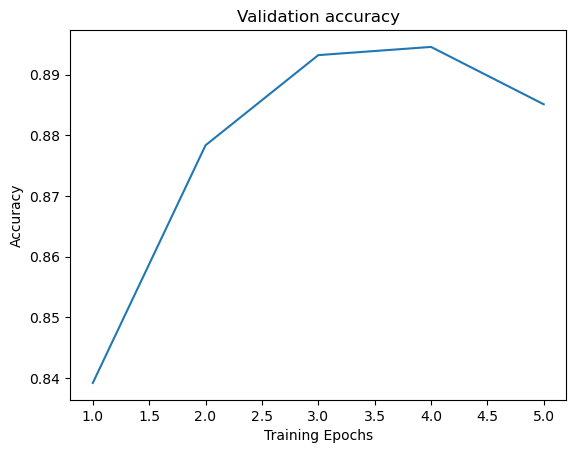

In [230]:
# Transform the history to a numpy array

# hist = torch.load("models/"+model_name_ext + "_hist" + ".pt")
ohist = [h.cpu().numpy() for h in hist]
ohist = np.array(ohist)



# Plot all accuracies
plt.title("Validation accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),ohist)
plt.show()


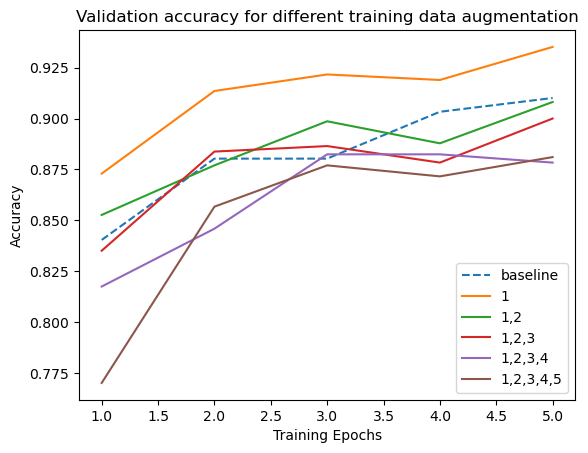

In [231]:
def ohist(hist):
    ohist = [h.cpu().numpy() for h in hist]
    ohist = np.array(ohist)
    return ohist

hist_base = torch.load("models/resnet18_False_1_14_50_hist.pt")
hist_1 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1.pt")
hist_1_2 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1_2.pt")
hist_1_2_3 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1_2_3.pt")
hist_1_2_3_4 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1_2_3_4.pt")
hist_1_2_3_4_5 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1_2_3_4_5.pt")

ohist_base = ohist(hist_base)
ohist_1 = ohist(hist_1)
ohist_1_2 = ohist(hist_1_2)
ohist_1_2_3 = ohist(hist_1_2_3)
ohist_1_2_3_4 = ohist(hist_1_2_3_4)
ohist_1_2_3_4_5 = ohist(hist_1_2_3_4_5)

# Plot all accuracies
plt.title("Validation accuracy for different training data augmentation")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),ohist_base[:num_epochs], label="baseline",linestyle="dashed")
plt.plot(range(1,num_epochs+1),ohist_1, label="1")
plt.plot(range(1,num_epochs+1),ohist_1_2, label="1,2")
plt.plot(range(1,num_epochs+1),ohist_1_2_3, label="1,2,3")
plt.plot(range(1,num_epochs+1),ohist_1_2_3_4, label="1,2,3,4")
plt.plot(range(1,num_epochs+1),ohist_1_2_3_4_5, label="1,2,3,4,5")
plt.legend()
plt.show()

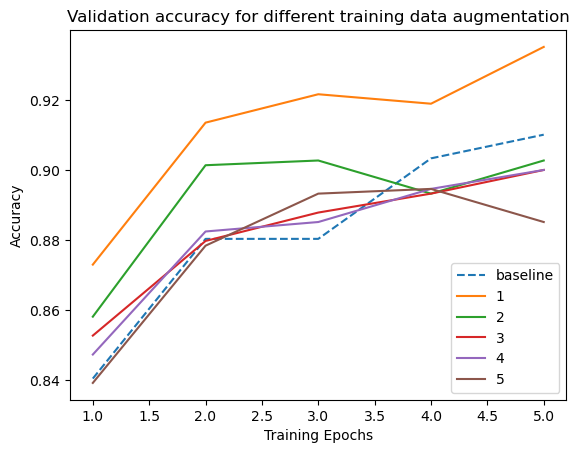

In [233]:
hist_base = torch.load("models/resnet18_False_1_14_50_hist.pt")
hist_1 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_1.pt")
hist_2 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_2.pt")
hist_3 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_3.pt")
hist_4 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_4.pt")
hist_5 = torch.load("models/resnet18_True_1_5_50_hist_filtertypes_5.pt")

ohist_base = ohist(hist_base)
ohist_1 = ohist(hist_1)
ohist_2 = ohist(hist_2)
ohist_3 = ohist(hist_3)
ohist_4 = ohist(hist_4)
ohist_5 = ohist(hist_5)

# Plot all accuracies
plt.title("Validation accuracy for different training data augmentation")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),ohist_base[:num_epochs], label="baseline",linestyle="dashed")
plt.plot(range(1,num_epochs+1),ohist_1, label="1")
plt.plot(range(1,num_epochs+1),ohist_2, label="2")
plt.plot(range(1,num_epochs+1),ohist_3, label="3")
plt.plot(range(1,num_epochs+1),ohist_4, label="4")
plt.plot(range(1,num_epochs+1),ohist_5, label="5")
plt.legend()
plt.show()